# TensorFlow Model Garden TF-Vision Project Example

In this Colab Notebook, we will be using a simple version of the YOLOv3 model for detection to show **how to create a TensorFlow Model Garden project by following [TFMG components](https://github.com/tensorflow/models/tree/master/official/vision/beta/projects/example)**. Also, how to use TensorFlow API and [TensorFlow Datasets](https://www.tensorflow.org/datasets) to support your TFMG project. 

> Note: As the goal of this tutorial is to show how to create a TFMG project, we choice to write a simple version of YOLOv3. Once your project meets the basic TFMG components, you can freely added subfolders under specific component folders to support your project. 
> 
> For advanced developers and researchers who already understand TFMG components, we have more comprehensive established projects. Please look at [MovieNet](https://github.com/tensorflow/models/tree/master/official/vision/beta/projects/movinet) and [YOLO](https://github.com/tensorflow/models/tree/master/official/vision/beta/projects/yolo) as examples. <font color='red'> (## TODO: May need to update the links.)</font>




## Understand the TFMG components

The TensorFlow Model Garden (TFMG) has a modular structure, supporting component re-use between exemplar implementations. The folders of the components include:

| Folders      | Required | Description                                                                                                                                                                                   |
|-------------|----------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| modeling    | yes      | Model and the building blocks.                                                                                                                                                                |
| losses      | yes      | Loss function.                                                                                                                                                                                |
| ops         | yes      | Operations: utility functions used by the data pipeline, loss function and modeling.                                                                                                          |
| dataloaders | yes      | Decoders and parsers for your data pipeline.                                                                                                                                                  |
| utils       | no       | Utility functions for external resources,  e.g. downloading weights, datasets from external sources, and the test cases for these functions. |
| configs     | yes      | The  config  files for the task class to train and evaluate the model.                                                                                                                        |
| tasks       | yes      | Tasks for running the model. Tasks are essentially the main driver for training and evaluating the model.                                                                                     |
| common      | yes      | Registry imports. The tasks and configs need to be registered before execution.                                                                                                             |
| demos       | no       | Files needed to create a Jupyter Notebook/Google Colab demo of the model. 

Modularity both simplifies implementation, andaccelerates innovation: model components can be recombined into a new model per-forming a different function. For example, the YOLO family is targeted towards object detection, but can be used for image classification by connecting an image classification head to the current backbone.


## Understand the YOLOv3 model

<!-- [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tensorflow/models/blob/master/official/vision/beta/projects/movinet/movinet_tutorial.ipynb) -->
<!-- [![TensorFlow Hub](https://img.shields.io/badge/TF%20Hub-Models-FF6F00?logo=tensorflow)](https://tfhub.dev/google/collections/movinet) -->


[![YOLOv3](http://img.shields.io/badge/Paper-arXiv.1804.02767-B3181B?logo=arXiv)](https://arxiv.org/abs/1804.02767)

In this tutorial, we implement the paper of YOLOv3 : 
[YOLOv3: An Incremental Improvement](https://arxiv.org/abs/1804.02767)


### Overview

YOLOv3

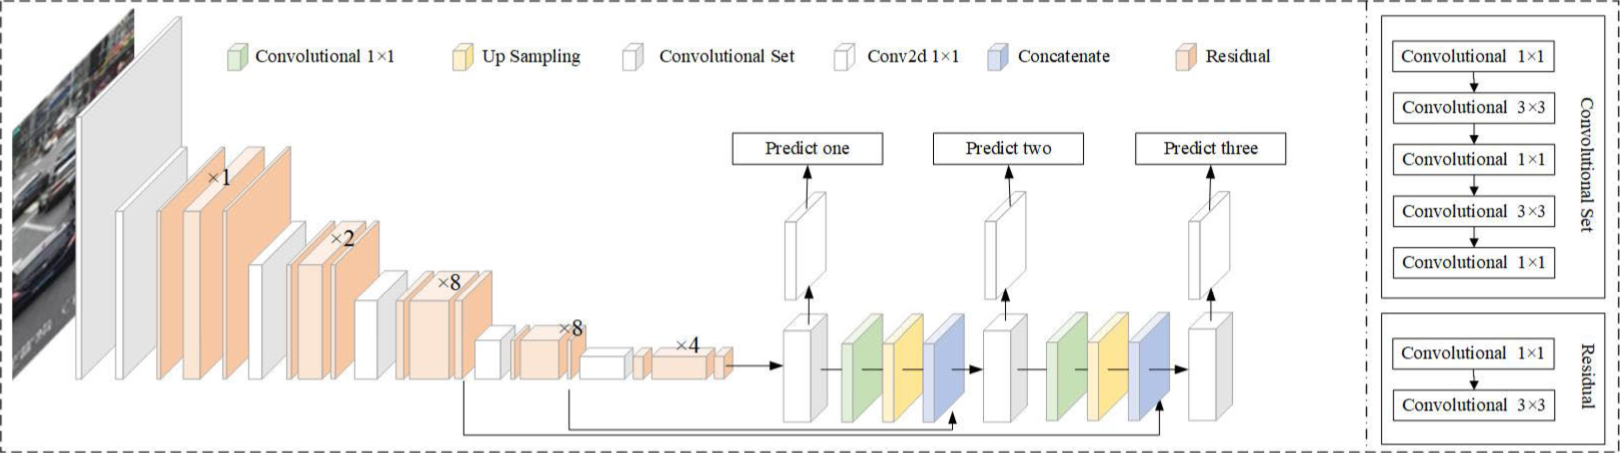

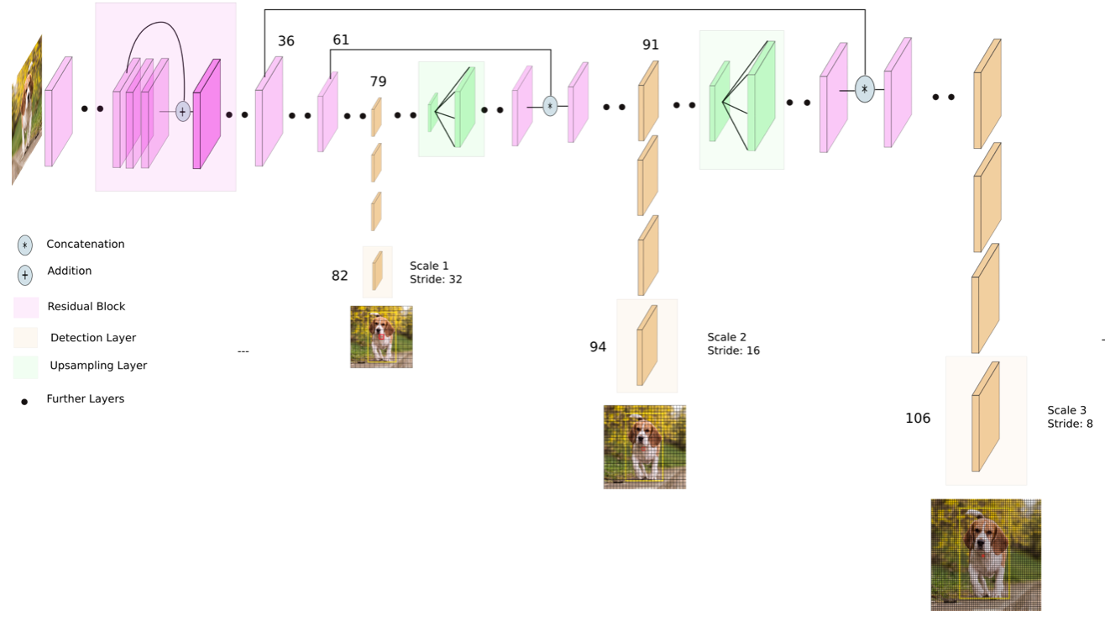

### Backbone Feature Extractor

YOLOv3 uses a new network architecture (DarkNet-53) for performing feature extraction, it's a hybrid approach between the network used in YOLOv2 (DarkNet-19) and residual network stuff. For the crucial functions of YOLOv3 (e.g. bounding boxes, non-max suppression, and IoU), we will provide the functions in the Step 1 (Create Model) and will use them in Step 4 (Create Task).

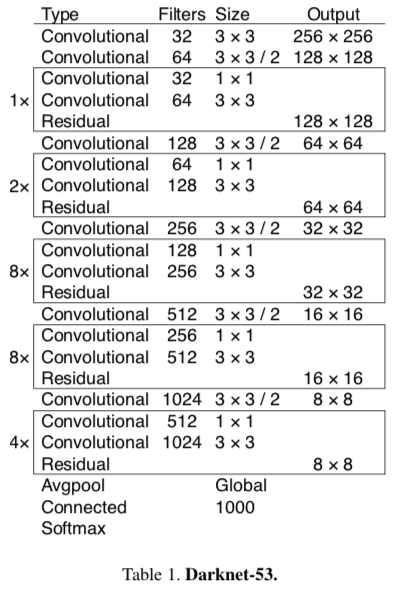

### Bounding Box Regression

In YOLOv2 (YOLO9000), they used bounding boxes in dimension clusters as anchor boxes then computed sum of squared loss.

In YOLOv3, they predict an objectness score for each bounding box using logistic regression. This should be 1 if the bounding box prior overlaps a ground truth object by more than any other bounding box prior. If the bounding box prior is not the best but does overlap a ground truth object by more than some threshold we ignore the prediction.

So, the functions defined below:

- Bounding boxes
- Intersection over Union (IoU)
- Non-Max Suppression (NMS)
- Sigmoid function


## Make YOLOv3 with TFMG components

Implement the YOLOv3 by following TFMG components, we can have the structure below:

1. Dataloaders:
    - Input images for prediction of detection task: 
        - `decoder()`: process original images to image data for tensor.
        - `parser()`: parse image data to tensor. 
    - (Utils) Load pre-trained weights into the YOLOv3 model:
        - `download_weights()`:
        - `load_weights_to_model()`:

2. Modeling:
    - `backbones()`
    - `bbox()`
    - `yolo_model()`

3. Ops:
    - `decode_netout()`: decode the prediction of detection model into boxes
    - `bbox_iou()`:
    - `nms()`: 
    - `loss()`: 

4. Configs: 
    - Image input config:
        - `image_path`:
        - `num_classes`: 
        - `input_size`: for modeling
    - Pretrain weights config:
        - `pb_file`: pretrain weights 
    - Modeling config:
        - `yolo3.yaml`

5. Tasks:
    - `build_input()`:
    - `build_model()`:
    - `build_loss()`:
    - metrics: 

6. Common / Import Registry:
    - include components above

7. Train:
    - `train.py`

8. Demo:
    - `demo.ipynb`

# Step 0: Setup

## 0.1 Install the TFMG requires

TensorFlow provides compenhensive framework and API tools to support TFMG. Here is briefly introduce: 

1. Install **TensorFlow 2** packages: 
    - `pip install tensorflow` : Latest stable release with CPU and GPU support (Ubuntu and Windows)
    - `pip install tf-nightly` : Preview build (unstable) . Ubuntu and Windows include GPU support .
    - For more details or older version, please check TF official document [here](https://www.tensorflow.org/install/pip). 


2. Install **TensorFlow Model Garden** packages: 
    - `pip install tf-models-official` : Latest stable Model Garden package. Note that it may not include the latest changes in the `tensorflow_models` github repo.
    - `pip install tf-models-nightly` : Preview build (unstable). Note that to include latest changes, you may install `tf-models-nightly`, which is the nightly Model Garden package created daily automatically. 


3. Install **TensorFlow Datasets** packages:
    - `pip install tensorflow-datasets` : The stable version, released every few months.
    - `pip install tfds-nightly` : Released every day, contains the last versions of the datasets.
    - For more details or older version, please check TFDS official document [here](https://www.tensorflow.org/datasets/overview). 


For above packages, `pip` will install all models and dependencies automatically.

In this Colab, we use the `nightly` versions of TFMG and TFDS, and the stable version of TF2 and TF Hub. Run the comments below:

In [2]:
# install TF2, TFMG, TFDS
# !pip install -q tensorflow tf-models-nightly tfds-nightly 

## 0.2 Provide a requirements file 

We recommend to write a `requirements.txt` file, as a part of your TFMG project, to install require packages with version numbers. So, when reusing the models project, we can run the commend to meet the requirement of the stable version of your project. 

```shell
$ !pip install -r yolo3/requirements.txt
```

## 0.3 TPU / GPU support

1. Google Cloud Platform (GCP) provides [documentation](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/README-TF2.1.md) to show you how to create an AI Platform Notebook attached to TPU v3-8 hardware. If you prefer to work with a notebook environment (which has terminal access) then it might be the easiest way to set up the compute. For setup GCP, please check our documentation [here](https://gsoc2021.readthedocs.io/en/latest/support/gcp.html)

2. To select a GPU/TPU in Colab,
    - GPU: select `Runtime > Change runtime type > Hardware accelerator` dropdown in the top menu. 
    If you upgraded to **[Colab PRO](https://colab.research.google.com/signup)**, check [![Colab Pro](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/notebooks/pro.ipynb) for using priority access to our fastest GPUs. 
    - TPU: select `Runtime` -> `Change runtime type` to `TPU`, then run the cell below to detect if using TPU backend now. 

In [1]:
# Detect hardware
import os
import tensorflow as tf 

try:
    tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu_address)
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print("Running on TPU", tpu.cluster_spec().as_dict()['worker'])
    print("Number of accelerators: ", strategy.num_replicas_in_sync)
except ValueError:
    print("TPU failed to initialize.")

## 0.4 Accessing Files

This [Snippets: Accessing files](https://colab.research.google.com/notebooks/snippets/accessing_files.ipynb) documentation shows how to access files for Colab. You can open files from Google Drive, GitHub, local file system, and Google Cloud Storage (GCS). 

For this tutorial, we use GCS to store COCO dataset.  

# Step 1: Create Dataloader

This section is following the Sec 1.1 (build YOLO from scratch), we can download pre-trained weigths from author's official source. We will have a DataLoader to load and parse weights into our DarkNet-53 architecture.

## 1.0 Example Dataloader

A dataloader reads, decodes and parses the input data. We have created various dataloaders to handle standard input formats for classification, detection and segmentation. If you have non-standard or complex data, you may want to create your own dataloader. It contains a `Decoder` and a `Parser`.

The `Decoder` decodes a TF Example record and returns a dictionary of decoded tensors:

```python
class Decoder(decoder.Decoder):
    """A tf.Example decoder for classification task."""
    def __init__(self):
        """Initializes the decoder.
        The constructor defines the mapping between the field name and the value
        from an input tf.Example. For example, we define two fields for image bytes
        and labels. There is no limit on the number of fields to decode.
        """
    self._keys_to_features = {
        'image/encoded': tf.io.FixedLenFeature((), tf.string, default_value=''),
        'image/class/label': tf.io.FixedLenFeature((), tf.int64, default_value=-1)
    }
```
The `Parser` parses the decoded tensors and performs pre-processing to the input data, such as image decoding, augmentation and resizing, etc. It should have `_parse_train_data` and `_parse_eval_data` functions, in which the processed images and labels are returned.

## 1.1 Dataloaders Component

In this section, 

### 1.1.1 Load dataset from TFDS 

TensorFlow provide many popular datasets [COCO](https://www.tensorflow.org/datasets/catalog/coco), [Kitti](), [VOC]() etc. For know the datatset, you can explore by this tool **[Know Your Data](https://knowyourdata-tfds.withgoogle.com/#dataset=kitti&tab=DATASETS&draw=kyd/kitti/objects_type,bbox,bbox&auto_draw=false)**, e.g. [COCO](https://knowyourdata-tfds.withgoogle.com/#dataset=coco&tab=STATS&draw=kyd/coco/objects_label,bbox,bbox&auto_draw=false). 



*Keywords: TFDS, Know Your Data.*

In [ ]:
import tensorflow_datasets as tfds
ds = tfds.load('coco', split='train', shuffle_files=True, as_supervised=True)

### 1.1.2 Preprocess input

In [ ]:
def preprocess_input(image, net_h, net_w):
    new_h, new_w, _ = image.shape

    # determine the new size of the image
    if (float(net_w)/new_w) < (float(net_h)/new_h):
        new_h = (new_h * net_w)/new_w
        new_w = net_w
    else:
        new_w = (new_w * net_h)/new_h
        new_h = net_h

    # resize the image to the new size
    resized = cv2.resize(image[:,:,::-1]/255., (int(new_w), int(new_h)))

    # embed the image into the standard letter box
    new_image = np.ones((net_h, net_w, 3)) * 0.5
    new_image[int((net_h-new_h)//2):int((net_h+new_h)//2), int((net_w-new_w)//2):int((net_w+new_w)//2), :] = resized
    new_image = np.expand_dims(new_image, 0)

    return new_image

### 1.1.3 Decode and parse 



In [ ]:
class MSCOCODecoder(decoder.Decoder):
    """Tensorflow Example proto decoder."""

    def __init__(self, include_mask=False, regenerate_source_id=False):
        self._include_mask = include_mask
        self._regenerate_source_id = regenerate_source_id
        if include_mask:
        raise ValueError("TensorFlow Datasets doesn't support masks")

    def _decode_image(self, parsed_tensors):
        """Decodes the image and set its static shape."""
        return parsed_tensors['image']

    def _decode_boxes(self, parsed_tensors):
        """Concat box coordinates in the format of [ymin, xmin, ymax, xmax]."""
        return parsed_tensors['objects']['bbox']

    def _decode_classes(self, parsed_tensors):
        return parsed_tensors['objects']['label']

    def _decode_areas(self, parsed_tensors):
        ymin = parsed_tensors['objects']['bbox'][..., 0]
        xmin = parsed_tensors['objects']['bbox'][..., 1]
        ymax = parsed_tensors['objects']['bbox'][..., 2]
        xmax = parsed_tensors['objects']['bbox'][..., 3]
        shape = tf.cast(tf.shape(parsed_tensors['image']), tf.float32)
        width = shape[0]
        height = shape[1]
        return (ymax - ymin) * (xmax - xmin) * width * height

    def _decode_masks(self, parsed_tensors):
        """Decode a set of PNG masks to the tf.float32 tensors."""
        return

    def decode(self, serialized_example):
        """Decode the serialized example.
        Args:
        serialized_example: a single serialized tf.Example string.
        Returns:
        decoded_tensors: a dictionary of tensors with the following fields:
            - source_id: a string scalar tensor.
            - image: a uint8 tensor of shape [None, None, 3].
            - height: an integer scalar tensor.
            - width: an integer scalar tensor.
            - groundtruth_classes: a int64 tensor of shape [None].
            - groundtruth_is_crowd: a bool tensor of shape [None].
            - groundtruth_area: a float32 tensor of shape [None].
            - groundtruth_boxes: a float32 tensor of shape [None, 4].
            - groundtruth_instance_masks: a float32 tensor of shape
                [None, None, None].
            - groundtruth_instance_masks_png: a string tensor of shape [None].
        """
        parsed_tensors = serialized_example
        image = self._decode_image(parsed_tensors)

        if 'image/id' in parsed_tensors.keys():
        source_id = parsed_tensors['image/id']
        else:
        ime = tf.io.encode_jpeg(image, quality=100)
        source_id = _generate_source_id(ime)

        boxes = self._decode_boxes(parsed_tensors)
        classes = self._decode_classes(parsed_tensors)
        areas = self._decode_areas(parsed_tensors)

        if 'is_crowd' in parsed_tensors['objects'].keys():
        is_crowd = tf.cond(
            tf.greater(tf.shape(classes)[0], 0),
            lambda: tf.cast(parsed_tensors['objects']['is_crowd'], dtype=tf.bool),
            lambda: tf.zeros_like(classes, dtype=tf.bool))
        else:
        is_crowd = tf.zeros_like(classes, dtype=tf.bool)

        decoded_tensors = {
            'source_id': source_id,
            'image': image,
            'width': tf.shape(parsed_tensors['image'])[0],
            'height': tf.shape(parsed_tensors['image'])[1],
            'groundtruth_classes': classes,
            'groundtruth_is_crowd': is_crowd,
            'groundtruth_area': areas,
            'groundtruth_boxes': boxes,
        }
        # tf.print(decoded_tensors)
        return decoded_tensors

## 1.2 Utils Component

The `utils` component is optional. In this case, we need to download and load weights into model. 

### 1.2.1 Download weights 

The utils component is optional. In this case, we need to download and load weights into model.
In practial, we can use the pre-treained models to do detection task directly.

Also, if we have custom improvement models, the pre-trained weights might be crucial to start training to achieve SOTA. 

The weights trained on COCO have been provided and can be loaded from official source. 

In [ ]:
# create a folder if no exist
!mkdir -p data

# load pre-trained DarkNet weights to `data/yolov[VERSION].weights`
!wget https://pjreddie.com/media/files/yolov1.weights -O data/yolov1.weights 
!wget https://pjreddie.com/media/files/yolov2.weights -O data/yolov2.weights 
!wget https://pjreddie.com/media/files/yolov3.weights -O data/yolov3.weights

--2021-07-23 20:46:47--  https://pjreddie.com/media/files/yolov1.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 789312988 (753M) [application/octet-stream]
Saving to: ‘data/yolov1.weights’

data/yolov1.weights 100%[===================>] 752.75M  39.0MB/s    in 20s     

2021-07-23 20:47:08 (38.1 MB/s) - ‘data/yolov1.weights’ saved [789312988/789312988]

--2021-07-23 20:47:08--  https://pjreddie.com/media/files/yolov2.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203934260 (194M) [application/octet-stream]
Saving to: ‘data/yolov2.weights’

data/yolov2.weights 100%[===================>] 194.49M  38.4MB/s    in 5.5s    

2021-07-23 20:47:14 (35.6 MB/s) - ‘data/yolov2.weights’ saved [203934260/20393426

### 1.2.2 Load pre-trained weights


After downloaded the pretrain weights, we can load the weights into our YOLOv3 model. 

In [ ]:
"""
input: weight_file
"""

class LoadWeights:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,    = struct.unpack('i', w_f.read(4))
            minor,    = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))

            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)

            transpose = (major > 1000) or (minor > 1000)
            
            binary = w_f.read()

        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))

                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))

                    size = np.prod(norm_layer.get_weights()[0].shape)

                    beta  = self.read_bytes(size) # bias
                    gamma = self.read_bytes(size) # scale
                    mean  = self.read_bytes(size) # mean
                    var   = self.read_bytes(size) # variance            

                    weights = norm_layer.set_weights([gamma, beta, mean, var])  

                if len(conv_layer.get_weights()) > 1:
                    bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))     
    
    def reset(self):
        self.offset = 0



# Step 2: Create Model

In this section, we will provide how YOLOv3 model can be created from scratch and how to load pre-trained models from TensorFlow Hub. 

In section 1.1, we provide an example how to build YOLOv3 from scratch, including the DarkNet architecture and other principle functions in YOLOv3. In section 1.2, we will update the usage of YOLO collections on TF hub soon once the pre-trained models and checkpoints have been published. 

## 2.0 Example Model

In `example_model`.py, we show how to create a new model. The ExampleModel is a subclass of `tf.keras.Model` that defines necessary parameters. Here, you need to have `input_specs` to specify the input shape and dimensions, and build layers within constructor:

```python
class ExampleModel(tf.keras.Model):
  def __init__(
    self,
    num_classes: int,
    input_specs: tf.keras.layers.InputSpec = tf.keras.layers.InputSpec(
        shape=[None, None, None, 3]),
    **kwargs):
    # Build layers.
```

Given the `ExampleModel`, you can define a function that takes a model config as input and return an `ExampleModel` instance, similar as `build_example_model`. As a simple example, we define a single model. However, you can split the model implementation to individual components, such as backbones, decoders, heads, as what we do here. And then in `build_example_model` function, you can hook up these components together to obtain your full model.

<font color='red'>(## TODO: The `build_example_model` above should link to a code snippet or github gist link, the link may claim in an internal doc of TF. )</font>

## 2.1 Modeling Component

Implement the Darknet-53 following by model example. 

In [ ]:
import argparse
import os
import numpy as np
# from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
# from tf.keras.layers.merge import add, concatenate
# from tf.keras.models import Model
import struct
import cv2

## modifed from exmaple_model.py => yolo3_model.py

"""A sample model implementation.
This is only a dummy example to showcase how a model is composed. It is usually
not needed to implement a modedl from scratch. Most SoTA models can be found and
directly used from `official/vision/beta/modeling` directory.
"""

from typing import Any, Mapping
# Import libraries
import tensorflow as tf
# from official.vision.beta.projects.yolo3 import yolo3_config 


@tf.keras.utils.register_keras_serializable(package='Vision')
class Yolo3Model(tf.keras.Model):
    """A example model class.
    A model is a subclass of tf.keras.Model where layers are built in the
    constructor.
    """
    def __init__(
        self,
        num_classes: int,
        input_specs: tf.keras.layers.InputSpec = tf.keras.layers.InputSpec(
            shape=[None, None, None, 3]),
        **kwargs):
        """Initializes the example model.
        All layers are defined in the constructor, and config is recorded in the
        `_config_dict` object for serialization.
        Args:
        num_classes: The number of classes in classification task.
        input_specs: A `tf.keras.layers.InputSpec` spec of the input tensor.
        **kwargs: Additional keyword arguments to be passed.
        """
        inputs = tf.keras.Input(shape=input_specs.shape[1:], name=input_specs.name)

        # Layer 0 => 1 : 
        outputs = self.conv_block(inputs, [
            {'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
            {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1}
        ], skip=False)

        # Layer 2 => 4 : Layer 4 Residual
        outputs = self.conv_block(outputs, [    
            {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
            {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}
        ], skip=True)

        # Layer 5 
        outputs = self.conv_block(outputs, [
            {'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5}
        ], skip=False)

        # Layer 6 => 11 : Layer 8/11 Residual
        for i in range(2):
            outputs = self.conv_block(outputs, [
                {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6 + i * 3},
                {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7 + i * 3}
            ], skip=True)

        # Layer 12 
        outputs = self.conv_block(outputs, [
            {'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12}
        ], skip=False)

        # Layer 13 => 36
        for i in range(8):
            outputs = self.conv_block(outputs, [
                {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13 + i * 3},
                {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14 + i * 3}
            ], skip=True)
        skip_36 = outputs

        # Layer 37 => 40
        outputs = self.conv_block(outputs, [
            {'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37}
        ], skip=False)

        # Layer 41 => 61
        for i in range(8):
            outputs = self.conv_block(outputs, [
                {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38 + i * 3},
                {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39 + i * 3}
            ])
        skip_61 = outputs

        # Layer 62 
        outputs = self.conv_block(outputs, [
            {'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62}
        ], skip=False)

        # Layer 63 => 74
        for i in range(4):
            outputs = self.conv_block(outputs, [
                {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63 + i * 3},
                {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64 + i * 3}
            ], skip=True)

        # Layer 75 => 80
        for i in range(3):
            outputs = self.conv_block(outputs, [
                {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75 + i * 2},
                {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76 + i * 2}
            ], skip=False)

        ## TODO: check the Layer 81

        # Layer 82
        yolo_82 = self.conv_block(outputs, [
            {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}
        ], skip=False)

        ## TODO: check layer_idx
        # Layer 83 => 86
        outputs = self.conv_block(outputs, [
            {'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}, 
        ], skip=False)
        outputs = tf.keras.layers.UpSampling2D(2)(outputs)
        outputs = tf.keras.layers.concatenate([outputs, skip_61])

        # Layer 87 => 92
        for i in range(3):
            outputs = self.conv_block(outputs, [
                {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87 + i * 2},
                {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88 + i * 2}
            ], skip=False)

        # Layer 93 => 94
        yolo_94 = self.conv_block(outputs, [
            {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}
        ])

        # Layer 95 => 98
        outputs = self.conv_block(outputs, [
            {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 96},
        ])
        outputs = tf.keras.layers.UpSampling2D(2)(outputs)
        outputs = tf.keras.layers.concatenate([outputs, skip_36])

        # Layer 99 => 106
        yolo_106 = self.conv_block(outputs, [
            {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 99},
            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 100},
            {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 101},
            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 102},
            {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 103},
            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 104},
            {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}
        ])
        
        # final model 
        self.model = tf.keras.Model(inputs, [yolo_82, yolo_94, yolo_106], name='yolo3_model')

        super().__init__(inputs=inputs, outputs=outputs, **kwargs)
        self._input_specs = input_specs
        self._config_dict = {
            'num_classes': num_classes, 
            'input_specs': input_specs
            }


    def conv_block(self, input_img, convs, skip=True):
        x = input_img
        count = 0
        for conv in convs:
            if count == (len(convs) - 2) and skip:
                skip_connection = x
            count += 1
            if conv['stride'] > 1:
                # peculiar padding as darknet prefer left and top
                x = tf.keras.layers.ZeroPadding2D(((1, 0), (1, 0)))(x)
            x = tf.keras.layers.Conv2D(
                    filters=conv['filter'],
                    kernel_size=conv['kernel'],
                    strides=conv['stride'],
                    # peculiar padding as darknet prefer left and top
                    padding='valid' if conv['stride'] > 1 else 'same',
                    name='conv_' + str(conv['layer_idx']), 
                    use_bias=False if conv['bnorm'] else True )(x)
            if conv['bnorm']:
                x = tf.keras.layers.BatchNormalization(
                    name='bnorm_' + str(conv['layer_idx']))(x)
            if conv['leaky']:
                x = tf.keras.layers.LeakyReLU(
                    alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
        return skip_connection + x if skip else x



    # def get_config(self) -> Mapping[str, Any]:
    #     """Gets the config of this model."""
    #     return self._config_dict

    # def from_config(cls, config, custom_objects=None):
    #     """Constructs an instance of this model from input config."""
    #     return cls(**config)


## 2.2 Ops Component

Bounding box in YOLOv3, play a crucial role. 

In [ ]:

def decode_netout(netout, anchors, obj_thresh, nms_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5

    boxes = []

    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh

    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            #objectness = netout[..., :4]
            
            if(objectness.all() <= obj_thresh): continue
            
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]

            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height  
            
            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            #box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, None, classes)

            boxes.append(box)

    return boxes


def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    if (float(net_w)/image_w) < (float(net_h)/image_h):
        new_w = net_w
        new_h = (image_h*net_w)/image_w
    else:
        new_h = net_w
        new_w = (image_w*net_h)/image_h
        
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
        
def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
        
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]

            if boxes[index_i].classes[c] == 0: continue

            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]

                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0
                    
def draw_boxes(image, boxes, labels, obj_thresh):
    for box in boxes:
        label_str = ''
        label = -1
        
        for i in range(len(labels)):
            if box.classes[i] > obj_thresh:
                label_str += labels[i]
                label = i
                print(labels[i] + ': ' + str(box.classes[i]*100) + '%')
                
        if label >= 0:
            cv2.rectangle(image, (box.xmin,box.ymin), (box.xmax,box.ymax), (0,255,0), 3)
            cv2.putText(image, 
                        label_str + ' ' + str(box.get_score()), 
                        (box.xmin, box.ymin - 13), 
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        1e-3 * image.shape[0], 
                        (0,255,0), 2)
        
    return image     

## 2.3 Loss Component

Loss functions with bbx for training a custom model and detaction tasks. 

In [ ]:
import numpy as np

class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        
        self.objness = objness
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
            
        return self.score

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3          

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    
    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union

# Step 3: Create Config

create config 

## 3.0 Example Config

Next you will define configs for your project. All configs are defined as dataclass objects, and can have default parameter values.

First, you will define your `ExampleDataConfig`. It inherits from `config_definitions.DataConfig` that already defines a few common fields, like `input_path`, `file_type`, `global_batch_size`, etc. You can add more fields in your own config as needed.

```python
@dataclasses.dataclass
class ExampleDataConfig(cfg.DataConfig):
    """Input config for training. Add more fields as needed."""
    input_path: str = ''
    global_batch_size: int = 0
    is_training: bool = True
    dtype: str = 'float32'
    shuffle_buffer_size: int = 10000
    cycle_length: int = 10
    file_type: str = 'tfrecord'
```

You can then define you model config `ExampleModel` that inherits from `hyperparams.Config`. Expose your own model parameters here.

```python
@dataclasses.dataclass
class ExampleModel(hyperparams.Config):
    """The model config. Used by build_example_model function."""
    num_classes: int = 0
    input_size: List[int] = dataclasses.field(default_factory=list)
```

You can then define your `Loss` and `Evaluation` configs.

```python
@dataclasses.dataclass
class Losses(hyperparams.Config):
    l2_weight_decay: float = 0.0

@dataclasses.dataclass
class Evaluation(hyperparams.Config):
    top_k: int = 5
```

Next, you will put all the above configs into an `ExampleTask` config. Here you list the configs for your data, model, loss, and evaluation, etc.

Finally, you can define a `tf_vision_example_experiment`, which creates a template for your experiments and fills with default parameters. These default parameter values can be overridden by a `YAML` file, like `example_config_tpu.yaml`. Also, make sure you give a unique name to your experiment template by the decorator:

```python
@exp_factory.register_config_factory('tf_vision_example_experiment')
def tf_vision_example_experiment() -> cfg.ExperimentConfig:
    """Definition of a full example experiment."""
    # Create and return experiment template.
```

## 3.1 Configs Component


### 3.1.1 Input config

### 3.1.2 Model config

In [ ]:
def build_yolo3_model(input_specs: tf.keras.layers.InputSpec,
                        model_config: yolo3_cfg.Yolo3Model,  ## TODO
                        **kwargs) -> tf.keras.Model:

    """Builds and returns the example model.
    This function is the main entry point to build a model. Commonly, it build a
    model by building a backbone, decoder and head. An example of building a
    classification model is at
    third_party/tensorflow_models/official/vision/beta/modeling/backbones/resnet.py.
    However, it is not mandatory for all models to have these three pieces
    exactly. Depending on the task, model can be as simple as the example model
    here or more complex, such as multi-head architecture.
    Args:
        input_specs: The specs of the input layer that defines input size.
        model_config: The config containing parameters to build a model.
        **kwargs: Additional keyword arguments to be passed.
    Returns:
        A tf.keras.Model object.
    """

    return Yolo3Model(
        num_classes=model_config.num_classes, input_specs=input_specs, **kwargs)

# Step 4: Create Task

tasks

## 4.0 Example Task

A task is a class that encapsules the logic of loading data, building models, performing one-step training and validation, etc. It connects all components together and is called by the base Trainer.

You can create your own task by inheriting from base Task, or from one of the tasks we already defined, if most of the operations can be reused. An `ExampleTask` inheriting from `ImageClassificationTask` can be found here. We will go through each important components in the task in the following.

- `build_model`: you can instantiate a model you have defined above. It is also good practice to run forward pass with a dummy input to ensure layers within the model are properly initialized, similar as this.

- `build_inputs`: here you can instantiate a Decoder object and a Parser object. They are used to create an InputReader that will generate a tf.data.Dataset object.

- `build_losses`: it takes groundtruth labels and model outputs as input, and computes the loss. It will be called in train_step and validation_step. You can also define different losses for training and validation, for example, build_train_losses and build_validation_losses. Just make sure they are called by the corresponding functions properly.

- `build_metrics`: here you can define your own metrics. It should return a list of tf.keras.metrics.Metric objects. You can create your own metric class by subclassing tf.keras.metrics.Metric.

- `train_step` and `validation_step`: they perform one-step training and validation. They take one batch of training/validation data, run forward pass, gather losses and update metrics. They assume the data format is consistency with that from the Parser output. train_step also contains backward pass to update model weights.

In [ ]:
## modified from example_task.py => yolo3_task.py

"""An example task definition for image classification."""
from typing import Any, List, Optional, Tuple, Sequence, Mapping

import tensorflow as tf

from official.common import dataset_fn
from official.core import base_task
from official.core import task_factory
from official.modeling import tf_utils
from official.vision.beta.dataloaders import input_reader_factory
from official.vision.beta.projects.yolo3 import yolo3_config as exp_cfg
from official.vision.beta.projects.yolo3 import yolo3_input
from official.vision.beta.projects.yolo3 import yolo3_model


@task_factory.register_task_cls(exp_cfg.ExampleTask)
class ExampleTask(base_task.Task):
  """Class of an example task.
  A task is a subclass of base_task.Task that defines model, input, loss, metric
  and one training and evaluation step, etc.
  """

  def build_model(self) -> tf.keras.Model:
    """Builds a model."""
    input_specs = tf.keras.layers.InputSpec(shape=[None] +
                                            self.task_config.model.input_size)

    model = yolo3_model.build_yolo3_model(
        input_specs=input_specs, model_config=self.task_config.model)
    return model

  def build_inputs(
      self,
      params: exp_cfg.ExampleDataConfig,
      input_context: Optional[tf.distribute.InputContext] = None
  ) -> tf.data.Dataset:
    """Builds input.
    The input from this function is a tf.data.Dataset that has gone through
    pre-processing steps, such as augmentation, batching, shuffuling, etc.
    Args:
      params: The experiment config.
      input_context: An optional InputContext used by input reader.
    Returns:
      A tf.data.Dataset object.
    """

    num_classes = self.task_config.model.num_classes
    input_size = self.task_config.model.input_size
    decoder = example_input.Decoder()

    parser = example_input.Parser(
        output_size=input_size[:2], num_classes=num_classes)

    reader = input_reader_factory.input_reader_generator(
        params,
        dataset_fn=dataset_fn.pick_dataset_fn(params.file_type),
        decoder_fn=decoder.decode,
        parser_fn=parser.parse_fn(params.is_training))

    dataset = reader.read(input_context=input_context)

    return dataset

  def build_losses(self,
                   labels: tf.Tensor,
                   model_outputs: tf.Tensor,
                   aux_losses: Optional[Any] = None) -> tf.Tensor:
    """Builds losses for training and validation.
    Args:
      labels: Input groundtruth labels.
      model_outputs: Output of the model.
      aux_losses: The auxiliarly loss tensors, i.e. `losses` in tf.keras.Model.
    Returns:
      The total loss tensor.
    """
    total_loss = tf.keras.losses.sparse_categorical_crossentropy(
        labels, model_outputs, from_logits=True)
    total_loss = tf_utils.safe_mean(total_loss)

    if aux_losses:
      total_loss += tf.add_n(aux_losses)

    return total_loss

  def build_metrics(self,
                    training: bool = True) -> Sequence[tf.keras.metrics.Metric]:
    """Gets streaming metrics for training/validation.
    This function builds and returns a list of metrics to compute during
    training and validation. The list contains objects of subclasses of
    tf.keras.metrics.Metric. Training and validation can have different metrics.
    Args:
      training: Whether the metric is for training or not.
    Returns:
     A list of tf.keras.metrics.Metric objects.
    """
    k = self.task_config.evaluation.top_k
    metrics = [
        tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(
            k=k, name='top_{}_accuracy'.format(k))
    ]
    return metrics

  def train_step(self,
                 inputs: Tuple[Any, Any],
                 model: tf.keras.Model,
                 optimizer: tf.keras.optimizers.Optimizer,
                 metrics: Optional[List[Any]] = None) -> Mapping[str, Any]:
    """Does forward and backward.
    This example assumes input is a tuple of (features, labels), which follows
    the output from data loader, i.e., Parser. The output from Parser is fed
    into train_step to perform one step forward and backward pass. Other data
    structure, such as dictionary, can also be used, as long as it is consistent
    between output from Parser and input used here.
    Args:
      inputs: A tuple of of input tensors of (features, labels).
      model: A tf.keras.Model instance.
      optimizer: The optimizer for this training step.
      metrics: A nested structure of metrics objects.
    Returns:
      A dictionary of logs.
    """
    features, labels = inputs
    num_replicas = tf.distribute.get_strategy().num_replicas_in_sync
    with tf.GradientTape() as tape:
      outputs = model(features, training=True)
      # Casting output layer as float32 is necessary when mixed_precision is
      # mixed_float16 or mixed_bfloat16 to ensure output is casted as float32.
      outputs = tf.nest.map_structure(lambda x: tf.cast(x, tf.float32), outputs)

      # Computes per-replica loss.
      loss = self.build_losses(
          model_outputs=outputs, labels=labels, aux_losses=model.losses)
      # Scales loss as the default gradients allreduce performs sum inside the
      # optimizer.
      scaled_loss = loss / num_replicas

      # For mixed_precision policy, when LossScaleOptimizer is used, loss is
      # scaled for numerical stability.
      if isinstance(optimizer, tf.keras.mixed_precision.LossScaleOptimizer):
        scaled_loss = optimizer.get_scaled_loss(scaled_loss)

    tvars = model.trainable_variables
    grads = tape.gradient(scaled_loss, tvars)
    # Scales back gradient before apply_gradients when LossScaleOptimizer is
    # used.
    if isinstance(optimizer, tf.keras.mixed_precision.LossScaleOptimizer):
      grads = optimizer.get_unscaled_gradients(grads)
    optimizer.apply_gradients(list(zip(grads, tvars)))

    logs = {self.loss: loss}
    if metrics:
      self.process_metrics(metrics, labels, outputs)
    return logs

  def validation_step(self,
                      inputs: Tuple[Any, Any],
                      model: tf.keras.Model,
                      metrics: Optional[List[Any]] = None) -> Mapping[str, Any]:
    """Runs validatation step.
    Args:
      inputs: A tuple of of input tensors of (features, labels).
      model: A tf.keras.Model instance.
      metrics: A nested structure of metrics objects.
    Returns:
      A dictionary of logs.
    """
    features, labels = inputs
    outputs = self.inference_step(features, model)
    outputs = tf.nest.map_structure(lambda x: tf.cast(x, tf.float32), outputs)
    loss = self.build_losses(
        model_outputs=outputs, labels=labels, aux_losses=model.losses)

    logs = {self.loss: loss}
    if metrics:
      self.process_metrics(metrics, labels, outputs)
    return logs

  def inference_step(self, inputs: tf.Tensor, model: tf.keras.Model) -> Any:
    """Performs the forward step. It is used in validation_step."""
    return model(inputs, training=False)

## 4.1 Tasks Component

### 4.1.1 Detection task for YOLOv3

If useing the pretrain model to do detection task directly, we can create a task below: 

In [ ]:
# config
weigth_path = 
image_path = 
net_h, het_w =
obj_threshold = 
nms_threshold =
labels = []


# build_model
# make the yolov3 model to predict 80 classes on COCO
yolov3 = make_yolov3_model()

# load the weights trained on COCO into the model
weight_reader = LoadWeights(weights_path)
weight_reader.load_weights(yolov3)


# build_inputs
# preprocess the image
image = cv2.imread(image_path)
image_h, image_w, _ = image.shape
new_image = preprocess_input(image, net_h, net_w)

# run the prediction
yolos = yolov3.predict(new_image)
boxes = []


# build_losses
# correct the sizes of the bounding boxes
correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w)

# suppress non-maximal boxes
do_nms(boxes, nms_thresh)     

# draw bounding boxes on the image using labels
draw_boxes(image, boxes, labels, obj_thresh) 

# write the image with bounding boxes to file
cv2.imwrite(image_path[:-4] + '_detected' + image_path[-4:], (image).astype('uint8')) 



### 4.1.2 Fine-tuning models task

For fine-tuning models, we can create a `example_task.py` below:

- `build_model()` :
- `build_inputs()` :
- `build_losses()` :
- `build_metrics()` :
- `train_step()` :
- `validation_step()` :
- `inference_step()` :

# Step 5: Common / Import Registry

## 5.0 Example Import Registry

To use your custom dataloaders, models, tasks, etc., you will need to register them properly. The recommended way is to have a single file with all relevant files imported, for example, `registry_imports.py`. You can see in this file we import all our custom components:

```python
"""All necessary imports for registration.
Custom models, task, configs, etc need to be imported to registry so they can be
picked up by the trainer. They can be included in this file so you do not need
to handle each file separately.
"""
# pylint: disable=unused-import
from tensorflow_models.official.common import registry_imports
from tensorflow_models.official.vision.beta.projects.example import example_config
from tensorflow_models.official.vision.beta.projects.example import example_input
from tensorflow_models.official.vision.beta.projects.example import example_model
from tensorflow_models.official.vision.beta.projects.example import example_task
```

## 5.1 Common Component



from tensorflow_models.official.common import registry_imports

In [ ]:
# pylint: disable=unused-import
from tensorflow_models.official.common import registry_imports
from tensorflow_models.official.vision.beta.projects.yolo3 import yolo3_config
from tensorflow_models.official.vision.beta.projects.yolo3 import yolo3_input
from tensorflow_models.official.vision.beta.projects.yolo3 import yolo3_model
from tensorflow_models.official.vision.beta.projects.yolo3 import yolo3_task

# Step 6: Train Model

Using Model Zoo as baseline + model train

## 6.0 Example Training 

You can create your own trainer by branching from our core trainer. Just make sure you import the registry like this:

```python
"""TensorFlow Model Garden Vision trainer.
All custom registry are imported from registry_imports. Here we use default
trainer so we directly call train.main. If you need to customize the trainer,
branch from `official/vision/beta/train.py` and make changes.
"""
from absl import app

from official.common import flags as tfm_flags
from official.vision.beta import train
from official.vision.beta.projects.example import registry_imports  # pylint: disable=unused-import

if __name__ == '__main__':
    tfm_flags.define_flags()
    app.run(train.main)
```

You can run training locally for testing purpose:
```bash
blaze run -c opt \
//third_party/tensorflow_models/official/vision/beta/projects/example:train -- \
  --experiment=tf_vision_example_experiment \
  --config_file=$PWD/third_party/tensorflow_models/official/vision/beta/projects/example/example_config_local.yaml \
  --mode=train \
  --model_dir=/tmp/tfvision_test/ \
  --alsologtostderr
```

## 6.1 Training the YOLOv3 model

In [ ]:
from tensorflow_models.official.vision.beta.projects.yolo3 import registry_imports  

# Step 7: Write Demo / Inference Colab

We recommend to write a **Colab** demo or inference tutorial, so your TFMG project can be reused the model. 

We also provide an example [here](). 

# <font color='red'> (## --- old version below --- ##)</font>

https://colab.research.google.com/gist/evawyf/8f38bf6722cdb6296c83c5f4e6812a3f/tfmg-project-tutorial.ipynb

4. After installed TensorFlow, install **TensorFlow Hub** package:
    - `pip install tensorflow-hub` : The stable version, work for both TensorFlow 2 and TensorFlow 1. We recommend that new users start with TensorFlow 2 right away, and current users upgrade to it.
    - `pip install tf-hub-nightly` : Built automatically from the source code on github, with no release testing. 
    - For more details, please check TF Hub official document [here](https://www.tensorflow.org/hub/installation)

```bash
$ !pip install -q tensorflow tensorflow-hub tf-models-nightly tfds-nightly 
```


The TensorFlow Model Garden (TFMG) has a modular structure, supporting component re-use between exemplar implementations. Modularity both simplifies implementation, andaccelerates innovation: model components can be recombined into a new model per-forming a different function. For example, the YOLO family is targeted towards object detection, but can be used for image classification by connecting an image classification head to the current backbone.


In this Colab Notebook, we will be using the YOLOv3 model to show how to create a TensorFlow Model Garden project by following [TFMG components](https://github.com/tensorflow/models/tree/master/official/vision/beta/projects/example). Also, TensorFlow provides compenhensive framework and API to support your TFMG project, including [TensorFlow Hub](https://www.tensorflow.org/hub) and [TensorFlow Datasets](https://www.tensorflow.org/datasets). 

In this tutorial, we provide a step-by-step example which works for both building a model from scratch and directly loading the pre-trained model from TensorFlow Hub for detection.



## 1.1 Build YOLOv3 from scratch

YOLOv3 uses a new network architecture (DarkNet-53) for performing feature extraction, it's a hybrid approach between the network used in YOLOv2 (DarkNet-19) and residual network stuff. For the crucial functions of YOLOv3 (e.g. bounding boxes, non-max suppression, and IoU), we will provide the functions in the Step 1 (Create Model) and will use them in Step 4 (Create Task). 


### 1.1.1 Build the DarkNet-53 Architecture

The network architecture of the model will be the **Model** component. 

Component: `example_model.py`

<font color='red'>(## TODO: need to check 81-83 layers)</font>

In [ ]:
## modifed from exmaple_model.py => yolo3_model.py

"""A sample model implementation.
This is only a dummy example to showcase how a model is composed. It is usually
not needed to implement a modedl from scratch. Most SoTA models can be found and
directly used from `official/vision/beta/modeling` directory.
"""

from typing import Any, Mapping
# Import libraries
import tensorflow as tf
from official.vision.beta.projects.yolo3 import yolo3_config as yolo3_cfg ## TODO 


@tf.keras.utils.register_keras_serializable(package='Vision')
class Yolo3Model(tf.keras.Model):
  """A example model class.
  A model is a subclass of tf.keras.Model where layers are built in the
  constructor.
  """
    def __init__(
        self,
        num_classes: int,
        input_specs: tf.keras.layers.InputSpec = tf.keras.layers.InputSpec(
            shape=[None, None, None, 3]),
        **kwargs):
        """Initializes the example model.
        All layers are defined in the constructor, and config is recorded in the
        `_config_dict` object for serialization.
        Args:
        num_classes: The number of classes in classification task.
        input_specs: A `tf.keras.layers.InputSpec` spec of the input tensor.
        **kwargs: Additional keyword arguments to be passed.
        """
        inputs = tf.keras.Input(shape=input_specs.shape[1:], name=input_specs.name)

        # Layer 0 => 1 : 
        outputs = self.conv_block(inputs, [
            {'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
            {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1}
        ], skip=False)

        # Layer 2 => 4 : Layer 4 Residual
        outputs = self.conv_block(outputs, [    
            {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
            {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}
        ], skip=True)

        # Layer 5 
        outputs = self.conv_block(outputs, [
            {'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5}
        ], skip=False)

        # Layer 6 => 11 : Layer 8/11 Residual
        for i in range(2):
            outputs = self.conv_block(outputs, [
                {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6 + i * 3},
                {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7 + i * 3}
            ], skip=True)

        # Layer 12 
        outputs = self.conv_block(outputs, [
            {'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12}
        ], skip=False)

        # Layer 13 => 36
        for i in range(8):
            outputs = self.conv_block(outputs, [
                {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13 + i * 3},
                {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14 + i * 3}
            ], skip=True)
        skip_36 = outputs

        # Layer 37 => 40
        outputs = self.conv_block(outputs, [
            {'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37}
        ], skip=False)

        # Layer 41 => 61
        for i in range(8):
            outputs = self.conv_block(outputs, [
                {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38 + i * 3},
                {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39 + i * 3}
            ])
        skip_61 = outputs

        # Layer 62 
        outputs = self.conv_block(outputs, [
            {'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62}
        ], skip=False)

        # Layer 63 => 74
        for i in range(4):
            outputs = self.conv_block(outputs, [
                {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63 + i * 3},
                {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64 + i * 3}
            ], skip=True)

        # Layer 75 => 80
        for i in range(3):
            outputs = self.conv_block(outputs, [
                {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75 + i * 2},
                {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76 + i * 2}
            ], skip=False)

        ## TODO: check the Layer 81

        # Layer 82
        yolo_82 = self.conv_block(outputs, [
            {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}
        ], skip=False)

        ## TODO: check layer_idx
        # Layer 83 => 86
        outputs = self.conv_block(outputs, [
            {'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}, 
        ], skip=False)
        outputs = tf.keras.layers.UpSampling2D(2)(outputs)
        outputs = tf.keras.layers.concatenate([outputs, skip_61])

        # Layer 87 => 92
        for i in range(3):
            outputs = self.conv_block(outputs, [
                {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87 + i * 2},
                {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88 + i * 2}
            ], skip=False)

        # Layer 93 => 94
        yolo_94 = self.conv_block(outputs, [
            {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}
        ])

        # Layer 95 => 98
        outputs = self.conv_block(outputs, [
            {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 96},
        ])
        outputs = tf.keras.layers.UpSampling2D(2)(outputs)
        outputs = tf.keras.layers.concatenate([outputs, skip_36])

        # Layer 99 => 106
        yolo_106 = self.conv_block(outputs, [
            {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 99},
            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 100},
            {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 101},
            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 102},
            {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 103},
            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 104},
            {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}
        ])
        
        # final model 
        self.model = tf.keras.Model(inputs, [yolo_82, yolo_94, yolo_106], name='yolo3_model')

        super().__init__(inputs=inputs, outputs=outputs, **kwargs)
        self._input_specs = input_specs
        self._config_dict = {'num_classes': num_classes, 'input_specs': input_specs}


    def conv_block(self, input_img, convs, skip=True):
        x = input_img
        count = 0
        for conv in convs:
            if count == (len(convs) - 2) and skip:
                skip_connection = x
            count += 1
            if conv['stride'] > 1:
                # peculiar padding as darknet prefer left and top
                x = tf.keras.layers.ZeroPadding2D(((1, 0), (1, 0)))(x)
            x = tf.keras.layers.Conv2D(
                    filters=conv['filter'],
                    kernel_size=conv['kernel'],
                    strides=conv['stride'],
                    # peculiar padding as darknet prefer left and top
                    padding='valid' if conv['stride'] > 1 else 'same',
                    name='conv_' + str(conv['layer_idx']), 
                    use_bias=False if conv['bnorm'] else True )(x)
            if conv['bnorm']:
                x = tf.keras.layers.BatchNormalization(
                    name='bnorm_' + str(conv['layer_idx']))(x)
            if conv['leaky']:
                x = tf.keras.layers.LeakyReLU(
                    alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
        return skip_connection + x if skip else x



    def get_config(self) -> Mapping[str, Any]:
        """Gets the config of this model."""
        return self._config_dict

    @classmethod
    def from_config(cls, config, custom_objects=None):
        """Constructs an instance of this model from input config."""
        return cls(**config)


def build_yolo3_model(input_specs: tf.keras.layers.InputSpec,
                        model_config: yolo3_cfg.Yolo3Model,  ## TODO
                        **kwargs) -> tf.keras.Model:

    """Builds and returns the example model.
    This function is the main entry point to build a model. Commonly, it build a
    model by building a backbone, decoder and head. An example of building a
    classification model is at
    third_party/tensorflow_models/official/vision/beta/modeling/backbones/resnet.py.
    However, it is not mandatory for all models to have these three pieces
    exactly. Depending on the task, model can be as simple as the example model
    here or more complex, such as multi-head architecture.
    Args:
        input_specs: The specs of the input layer that defines input size.
        model_config: The config containing parameters to build a model.
        **kwargs: Additional keyword arguments to be passed.
    Returns:
        A tf.keras.Model object.
    """

    return Yolo3Model(
        num_classes=model_config.num_classes, input_specs=input_specs, **kwargs)


<font color='red'>(## TODO: helping check architecture, it will be removed after)</font>

```bash
$ ./darknet detect cfg/yolov3.cfg yolov3.weights data/dog.jpg                                                                                                                                                    [2:24:08]
layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 152 x 128   ->   152 x 152 x 128
   12 conv    256  3 x 3 / 2   152 x 152 x 128   ->    76 x  76 x 256  3.407 BFLOPs
   13 conv    128  1 x 1 / 1    76 x  76 x 256   ->    76 x  76 x 128  0.379 BFLOPs
   14 conv    256  3 x 3 / 1    76 x  76 x 128   ->    76 x  76 x 256  3.407 BFLOPs
   15 res   12                  76 x  76 x 256   ->    76 x  76 x 256
   16 conv    128  1 x 1 / 1    76 x  76 x 256   ->    76 x  76 x 128  0.379 BFLOPs
   17 conv    256  3 x 3 / 1    76 x  76 x 128   ->    76 x  76 x 256  3.407 BFLOPs
   18 res   15                  76 x  76 x 256   ->    76 x  76 x 256
   19 conv    128  1 x 1 / 1    76 x  76 x 256   ->    76 x  76 x 128  0.379 BFLOPs
   20 conv    256  3 x 3 / 1    76 x  76 x 128   ->    76 x  76 x 256  3.407 BFLOPs
   21 res   18                  76 x  76 x 256   ->    76 x  76 x 256
   22 conv    128  1 x 1 / 1    76 x  76 x 256   ->    76 x  76 x 128  0.379 BFLOPs
   23 conv    256  3 x 3 / 1    76 x  76 x 128   ->    76 x  76 x 256  3.407 BFLOPs
   24 res   21                  76 x  76 x 256   ->    76 x  76 x 256
   25 conv    128  1 x 1 / 1    76 x  76 x 256   ->    76 x  76 x 128  0.379 BFLOPs
   26 conv    256  3 x 3 / 1    76 x  76 x 128   ->    76 x  76 x 256  3.407 BFLOPs
   27 res   24                  76 x  76 x 256   ->    76 x  76 x 256
   28 conv    128  1 x 1 / 1    76 x  76 x 256   ->    76 x  76 x 128  0.379 BFLOPs
   29 conv    256  3 x 3 / 1    76 x  76 x 128   ->    76 x  76 x 256  3.407 BFLOPs
   30 res   27                  76 x  76 x 256   ->    76 x  76 x 256
   31 conv    128  1 x 1 / 1    76 x  76 x 256   ->    76 x  76 x 128  0.379 BFLOPs
   32 conv    256  3 x 3 / 1    76 x  76 x 128   ->    76 x  76 x 256  3.407 BFLOPs
   33 res   30                  76 x  76 x 256   ->    76 x  76 x 256
   34 conv    128  1 x 1 / 1    76 x  76 x 256   ->    76 x  76 x 128  0.379 BFLOPs
   35 conv    256  3 x 3 / 1    76 x  76 x 128   ->    76 x  76 x 256  3.407 BFLOPs
   36 res   33                  76 x  76 x 256   ->    76 x  76 x 256
   37 conv    512  3 x 3 / 2    76 x  76 x 256   ->    38 x  38 x 512  3.407 BFLOPs
   38 conv    256  1 x 1 / 1    38 x  38 x 512   ->    38 x  38 x 256  0.379 BFLOPs
   39 conv    512  3 x 3 / 1    38 x  38 x 256   ->    38 x  38 x 512  3.407 BFLOPs
   40 res   37                  38 x  38 x 512   ->    38 x  38 x 512
   41 conv    256  1 x 1 / 1    38 x  38 x 512   ->    38 x  38 x 256  0.379 BFLOPs
   42 conv    512  3 x 3 / 1    38 x  38 x 256   ->    38 x  38 x 512  3.407 BFLOPs
   43 res   40                  38 x  38 x 512   ->    38 x  38 x 512
   44 conv    256  1 x 1 / 1    38 x  38 x 512   ->    38 x  38 x 256  0.379 BFLOPs
   45 conv    512  3 x 3 / 1    38 x  38 x 256   ->    38 x  38 x 512  3.407 BFLOPs
   46 res   43                  38 x  38 x 512   ->    38 x  38 x 512
   47 conv    256  1 x 1 / 1    38 x  38 x 512   ->    38 x  38 x 256  0.379 BFLOPs
   48 conv    512  3 x 3 / 1    38 x  38 x 256   ->    38 x  38 x 512  3.407 BFLOPs
   49 res   46                  38 x  38 x 512   ->    38 x  38 x 512
   50 conv    256  1 x 1 / 1    38 x  38 x 512   ->    38 x  38 x 256  0.379 BFLOPs
   51 conv    512  3 x 3 / 1    38 x  38 x 256   ->    38 x  38 x 512  3.407 BFLOPs
   52 res   49                  38 x  38 x 512   ->    38 x  38 x 512
   53 conv    256  1 x 1 / 1    38 x  38 x 512   ->    38 x  38 x 256  0.379 BFLOPs
   54 conv    512  3 x 3 / 1    38 x  38 x 256   ->    38 x  38 x 512  3.407 BFLOPs
   55 res   52                  38 x  38 x 512   ->    38 x  38 x 512
   56 conv    256  1 x 1 / 1    38 x  38 x 512   ->    38 x  38 x 256  0.379 BFLOPs
   57 conv    512  3 x 3 / 1    38 x  38 x 256   ->    38 x  38 x 512  3.407 BFLOPs
   58 res   55                  38 x  38 x 512   ->    38 x  38 x 512
   59 conv    256  1 x 1 / 1    38 x  38 x 512   ->    38 x  38 x 256  0.379 BFLOPs
   60 conv    512  3 x 3 / 1    38 x  38 x 256   ->    38 x  38 x 512  3.407 BFLOPs
   61 res   58                  38 x  38 x 512   ->    38 x  38 x 512
   62 conv   1024  3 x 3 / 2    38 x  38 x 512   ->    19 x  19 x1024  3.407 BFLOPs
   63 conv    512  1 x 1 / 1    19 x  19 x1024   ->    19 x  19 x 512  0.379 BFLOPs
   64 conv   1024  3 x 3 / 1    19 x  19 x 512   ->    19 x  19 x1024  3.407 BFLOPs
   65 res   62                  19 x  19 x1024   ->    19 x  19 x1024
   66 conv    512  1 x 1 / 1    19 x  19 x1024   ->    19 x  19 x 512  0.379 BFLOPs
   67 conv   1024  3 x 3 / 1    19 x  19 x 512   ->    19 x  19 x1024  3.407 BFLOPs
   68 res   65                  19 x  19 x1024   ->    19 x  19 x1024
   69 conv    512  1 x 1 / 1    19 x  19 x1024   ->    19 x  19 x 512  0.379 BFLOPs
   70 conv   1024  3 x 3 / 1    19 x  19 x 512   ->    19 x  19 x1024  3.407 BFLOPs
   71 res   68                  19 x  19 x1024   ->    19 x  19 x1024
   72 conv    512  1 x 1 / 1    19 x  19 x1024   ->    19 x  19 x 512  0.379 BFLOPs
   73 conv   1024  3 x 3 / 1    19 x  19 x 512   ->    19 x  19 x1024  3.407 BFLOPs
   74 res   71                  19 x  19 x1024   ->    19 x  19 x1024
   75 conv    512  1 x 1 / 1    19 x  19 x1024   ->    19 x  19 x 512  0.379 BFLOPs
   76 conv   1024  3 x 3 / 1    19 x  19 x 512   ->    19 x  19 x1024  3.407 BFLOPs
   77 conv    512  1 x 1 / 1    19 x  19 x1024   ->    19 x  19 x 512  0.379 BFLOPs
   78 conv   1024  3 x 3 / 1    19 x  19 x 512   ->    19 x  19 x1024  3.407 BFLOPs
   79 conv    512  1 x 1 / 1    19 x  19 x1024   ->    19 x  19 x 512  0.379 BFLOPs
   80 conv   1024  3 x 3 / 1    19 x  19 x 512   ->    19 x  19 x1024  3.407 BFLOPs
   81 conv    255  1 x 1 / 1    19 x  19 x1024   ->    19 x  19 x 255  0.189 BFLOPs
   82 yolo
   83 route  79
   84 conv    256  1 x 1 / 1    19 x  19 x 512   ->    19 x  19 x 256  0.095 BFLOPs
   85 upsample            2x    19 x  19 x 256   ->    38 x  38 x 256
   86 route  85 61
   87 conv    256  1 x 1 / 1    38 x  38 x 768   ->    38 x  38 x 256  0.568 BFLOPs
   88 conv    512  3 x 3 / 1    38 x  38 x 256   ->    38 x  38 x 512  3.407 BFLOPs
   89 conv    256  1 x 1 / 1    38 x  38 x 512   ->    38 x  38 x 256  0.379 BFLOPs
   90 conv    512  3 x 3 / 1    38 x  38 x 256   ->    38 x  38 x 512  3.407 BFLOPs
   91 conv    256  1 x 1 / 1    38 x  38 x 512   ->    38 x  38 x 256  0.379 BFLOPs
   92 conv    512  3 x 3 / 1    38 x  38 x 256   ->    38 x  38 x 512  3.407 BFLOPs
   93 conv    255  1 x 1 / 1    38 x  38 x 512   ->    38 x  38 x 255  0.377 BFLOPs
   94 yolo
   95 route  91
   96 conv    128  1 x 1 / 1    38 x  38 x 256   ->    38 x  38 x 128  0.095 BFLOPs
   97 upsample            2x    38 x  38 x 128   ->    76 x  76 x 128
   98 route  97 36
   99 conv    128  1 x 1 / 1    76 x  76 x 384   ->    76 x  76 x 128  0.568 BFLOPs
  100 conv    256  3 x 3 / 1    76 x  76 x 128   ->    76 x  76 x 256  3.407 BFLOPs
  101 conv    128  1 x 1 / 1    76 x  76 x 256   ->    76 x  76 x 128  0.379 BFLOPs
  102 conv    256  3 x 3 / 1    76 x  76 x 128   ->    76 x  76 x 256  3.407 BFLOPs
  103 conv    128  1 x 1 / 1    76 x  76 x 256   ->    76 x  76 x 128  0.379 BFLOPs
  104 conv    256  3 x 3 / 1    76 x  76 x 128   ->    76 x  76 x 256  3.407 BFLOPs
  105 conv    255  1 x 1 / 1    76 x  76 x 256   ->    76 x  76 x 255  0.754 BFLOPs
  106 yolo
Loading weights from yolov3.weights...Done!
data/dog.jpg: Predicted in 24.269431 seconds.
bicycle: 99%
truck: 92%
dog: 100%
```

## 1.2 Load from TensorFlow Hub 

<font color='red'>(## TODO: This section will be added after YOLO collection published. )</font>

TensorFlow Hub is a repository of trained machine learning models ready for fine-tuning and deployable anywhere. Reuse trained models like BERT and Faster R-CNN with just a few lines of code.

We will update the TF hub link here after the YOLO collections published. 

### 1.2.1 SavedModels in TensorFlow Hub (`tfhub.dev`)

> (TODO) Publishing process: https://www.tensorflow.org/hub/publish

```python
import tensorflow_hub as hub

model = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2")
embeddings = model(["The rain in Spain.", "falls",
                    "mainly", "In the plain!"])

print(embeddings.shape)  #(4,128)
```

### 1.2.2 Example Using SavedModels from TF Hub

> (TODO) SavedModels from TF Hub in TensorFlow 2: https://www.tensorflow.org/hub/tf2_saved_model

Load YOLO-Base from TensorFlow Hub, as part of the [YOLO collection](LINK).

The following code will:

- Load a YOLO KerasLayer from [tfhub.dev](https://tfhub.dev).
- Wrap the layer in a [Keras Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model).
- Load an example image, and do object detection. 

# Step 2: Create Dataloader

This section is following the Sec 1.1 (build YOLO from scratch), we can download pre-trained weigths from author's official source. We will have a `DataLoader` to load and parse weights into our DarkNet-53 architecture. 


#### TensorFlow Datasets Instruction

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/datasets/overview"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/datasets/blob/master/docs/overview.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/datasets/blob/master/docs/overview.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/datasets/docs/overview.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In [ ]:
%env JOBLIB_TEMP_FOLDER=/tmp
# rm -r /tmp/

env: JOBLIB_TEMP_FOLDER=/tmp


In [ ]:
!pip install -q tfds-nightly tensorflow matplotlib

     |████████████████████████████████| 4.0 MB 4.0 MB/s 


In [ ]:
# !pip install tensorflow-datasets
import tensorflow_datasets as tfds
import tensorflow as tf

In [ ]:
# Construct a tf.data.Dataset
ds = tfds.load('voc', split='train', as_supervised=False, shuffle_files=True)

# Build your input pipeline
ds = ds.shuffle(1000).batch(128).prefetch(10).take(5)

Dataset voc downloaded and prepared to /root/tensorflow_datasets/voc/2007/4.0.0. Subsequent calls will reuse this data.
(16, 500, 500, 3)


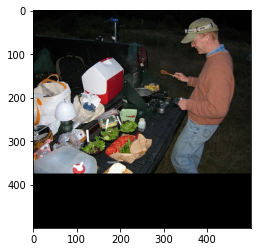

tf.Tensor(
[[0.048 0.632 1.    0.93 ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]], shape=(5, 4), dtype=float32)


In [ ]:
%matplotlib inline

# tfds works in both Eager and Graph modes
tf.compat.v1.enable_eager_execution()

dataset = tfds.load("voc", split=tfds.Split.TRAIN, batch_size=16)
dataset = dataset.shuffle(10)

for feature in dataset.take(1):
    print(feature['image'].shape)

plt.imshow(feature['image'][5])
plt.show()

print(feature['objects']['bbox'][5])